https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/get_started_pytorch.py


In [1]:
%pip install torch==2.7.0 adversarial-robustness-toolbox==1.19.1 torchvision==0.22.0

Looking in indexes: https://pypi.python.org/simple


Training model...
Epoch 1 loss: 0.2392
Epoch 2 loss: 0.0584
Epoch 3 loss: 0.0429
Clean accuracy: 98.84%
Adversarial accuracy (first batch): 39.70%


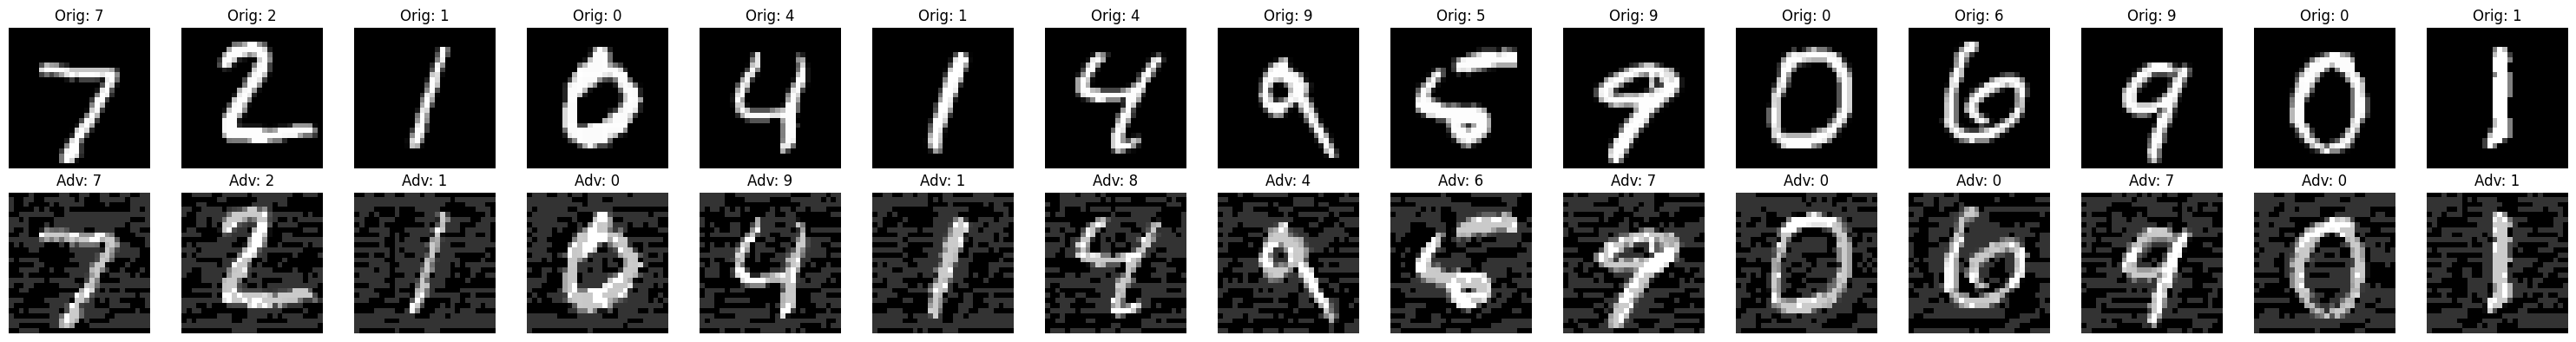

In [2]:
# requirements:
#   pip install torch torchvision adversarial-robustness-toolbox matplotlib numpy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier

# 1. Prepare MNIST loaders
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # scales to [0,1]
    ]
)
trainset = torchvision.datasets.MNIST(
    root="./data_gitignore", train=True, download=True, transform=transform
)
testset = torchvision.datasets.MNIST(
    root="./data_gitignore", train=False, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)


# 2. Define simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        return self.net(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# 3. Train model (few epochs for demo)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Training model...")
model.train()
for epoch in range(3):
    running_loss = 0.0
    for X, y in trainloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
    print(f"Epoch {epoch+1} loss: {running_loss/len(trainset):.4f}")

# 4. Wrap in ART PyTorchClassifier
# Note: classifier expects logits, so no softmax in model.
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0.0, 1.0),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
    device_type="gpu" if torch.cuda.is_available() else "cpu",
)

# 5. Evaluate on clean test data
model.eval()
correct = 0
total = 0
for X, y in testloader:
    preds = classifier.predict(X.numpy())
    labels = np.argmax(preds, axis=1)
    correct += (labels == y.numpy()).sum()
    total += y.size(0)
print(f"Clean accuracy: {100*correct/total:.2f}%")

# 6. Create and run FGSM attack
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test = next(iter(testloader))[0].numpy()  # take first batch
y_test = next(iter(testloader))[1].numpy()
x_test_adv = attack.generate(x=x_test)

# 7. Evaluate on adversarial examples
preds_adv = classifier.predict(x_test_adv)
acc_adv = np.mean(np.argmax(preds_adv, axis=1) == y_test)
print(f"Adversarial accuracy (first batch): {100*acc_adv:.2f}%")

# 8. Visualize some examples
n = 15  # number of pairs to show (so 2*n = 30 images)
plt.figure(figsize=(int(n*2), 4))
for i in range(n):
    # original
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap="gray")
    plt.title(f"Orig: {y_test[i]}")
    plt.axis("off")

    # adversarial
    plt.subplot(2, n, n + i + 1)
    plt.imshow(x_test_adv[i].squeeze(), cmap="gray")
    plt.title(f"Adv: {np.argmax(preds_adv[i])}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Attack 1 successful! Perturbation score: 7.1776


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Attack 2 successful! Perturbation score: 46.2350


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Attack 3 successful! Perturbation score: 23.0523


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Attack 4 successful! Perturbation score: 20.4325


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Attack 5 successful! Perturbation score: 33.5279


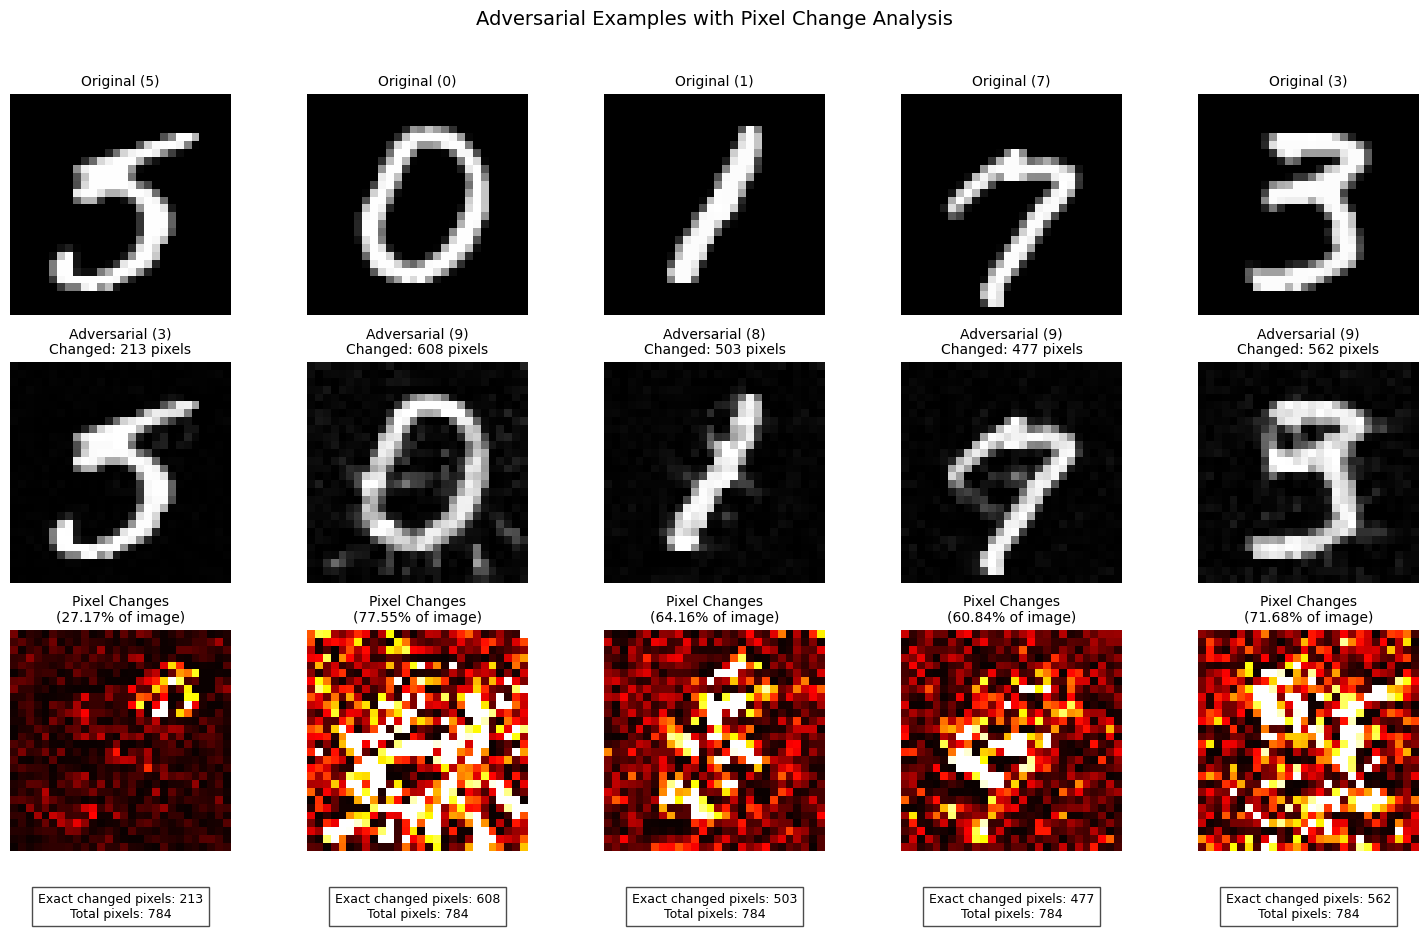

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import BoundaryAttack
import torchvision
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST Dataset
transform = torchvision.transforms.ToTensor()
testset = torchvision.datasets.MNIST(
    root="./data_gitignore", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)


# Model definition (same as before)
class MNISTCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# Check if model file exists, if not, train and save it
model = MNISTCNN().to(device)
if not os.path.exists("mnist_cnn.pth"):
    print("Training model as mnist_cnn.pth was not found...")
    # Load training data
    trainset = torchvision.datasets.MNIST(
        root="./data_gitignore", train=True, download=True, transform=transform
    )
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    
    # Define optimizer and loss
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Train for 4 epochs (quick training)
    num_epochs = 4
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0
    
    # Save the model
    torch.save(model.state_dict(), "mnist_cnn.pth")
    print("Model trained and saved as mnist_cnn.pth")
else:
    # Load trained model
    model.load_state_dict(torch.load("mnist_cnn.pth"))

model.eval()

# ART classifier
classifier = PyTorchClassifier(
    model=model,
    loss=nn.CrossEntropyLoss(),
    input_shape=(1, 28, 28),
    nb_classes=10,
    clip_values=(0, 1),
    device_type="gpu" if torch.cuda.is_available() else "cpu",
)

# Configure BoundaryAttack
attack = BoundaryAttack(
    estimator=classifier,
    targeted=False,  # Make this an untargeted attack
    batch_size=1,
    max_iter=1000,  # Increased iterations for better results
    num_trial=20,  # Number of trial steps per iteration
    sample_size=40,  # Number of random samples for gradient estimation
    verbose=True,
)

# Collect adversarial examples
success_count = 0
max_samples = 100
results = []

for idx, (x, y) in enumerate(testloader):
    if success_count >= 5 or idx >= max_samples:
        break

    x_np = x.numpy().astype(np.float32)  # Explicitly convert to float32
    y_true = y.item()

    # Skip misclassified samples
    if np.argmax(classifier.predict(x_np)) != y_true:
        continue

    try:
        # Generate adversarial example
        x_adv = attack.generate(x=x_np)

        # Verify attack success
        y_adv = np.argmax(classifier.predict(x_adv))
        if y_adv != y_true:
            success_count += 1
            perturbation = np.abs(x_np - x_adv).sum()
            results.append(
                {
                    "original": x_np.squeeze(),
                    "adversarial": x_adv.squeeze(),
                    "true_label": y_true,
                    "adv_label": y_adv,
                    "perturbation": perturbation,
                }
            )
            print(
                f"Attack {success_count} successful! Perturbation score: {perturbation:.4f}"
            )
    except Exception as e:
        print(f"Attack failed: {str(e)}")

# Visualization with pixel change info
if success_count > 0:
    fig, axs = plt.subplots(3, min(5, success_count), figsize=(15, 9))

    for i in range(min(5, success_count)):
        result = results[i]
        orig_img = result["original"] 
        adv_img = result["adversarial"]
        true_label = result["true_label"]
        adv_label = result["adv_label"]

        # Calculate pixel changes
        diff = np.abs(orig_img - adv_img)
        changed_pixels = np.sum(diff > 0.01)  # Threshold to account for float precision
        total_pixels = orig_img.size
        change_percent = 100 * changed_pixels / total_pixels

        # Original image
        axs[0, i].imshow(orig_img, cmap="gray")
        axs[0, i].set_title(f"Original ({true_label})", fontsize=10)
        axs[0, i].axis("off")

        # Adversarial image
        axs[1, i].imshow(adv_img, cmap="gray")
        axs[1, i].set_title(
            f"Adversarial ({adv_label})\nChanged: {changed_pixels} pixels", fontsize=10
        )
        axs[1, i].axis("off")

        # Difference image (enhanced)
        diff_enhanced = np.clip(diff * 10, 0, 1)  # Amplify differences
        axs[2, i].imshow(diff_enhanced, cmap="hot")
        axs[2, i].set_title(
            f"Pixel Changes\n({change_percent:.2f}% of image)", fontsize=10
        )
        axs[2, i].axis("off")

        # Add text annotation
        axs[2, i].text(
            0.5,
            -0.3,
            f"Exact changed pixels: {changed_pixels}\nTotal pixels: {total_pixels}",
            ha="center",
            transform=axs[2, i].transAxes,
            fontsize=9,
            bbox=dict(facecolor="white", alpha=0.7),
        )

    plt.suptitle("Adversarial Examples with Pixel Change Analysis", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()
